In [1]:
from pprint import pprint as pp
from typing import Dict, List, Tuple

import random
import csv

# Building Knowledge Graph

## Extract Data from CSV

In [2]:
def get_csv_data(filepath, handle_row_func):
    data = dict()
    with open(filepath) as file:
        next(file)
        rows = csv.reader(file, delimiter=",")
        for row in rows:
            handle_row_func(data, row)
    return data

In [3]:
def handle_csv_kanji_func(data, row):
    kanji,*meanings = row
    if len(meanings) >= 2:
        meanings = ",".join(meanings)
    else:
        meanings = meanings[0]
    meanings = meanings.split(":")
    meanings = meanings[0]
    data[kanji] = meanings

In [4]:
data_kanji = get_csv_data("dataset/s5_kanjis_output.csv", handle_csv_kanji_func)
print("len(data_kanji) = ", len(data_kanji))
# pp(data_kanji)

len(data_kanji) =  6215


In [5]:
def handle_csv_radical_func(data, row):
    radical,meaning,_ = row
    data[radical] = meaning

In [6]:
data_radical = get_csv_data("dataset/s7_nodes_radical_meaning.csv", handle_csv_radical_func)
print("len(data_radical) = ", len(data_radical))
# pp(data_radical)

len(data_radical) =  255


In [7]:
def handle_csv_edges_func(data, row):
    kanji,radical_list = row
    data[kanji] = radical_list.split(':')

In [8]:
data_edges = get_csv_data("dataset/s7_edges_kanji_radical.csv", handle_csv_edges_func)
print("len(data_edges) = ", len(data_edges))
# pp(data_edges)

len(data_edges) =  6215


## Data Structure

### Node Manager

In [ ]:
def get_key(symbol, dtype):
    return f"{symbol}-{dtype}"

In [10]:
node_kanji = {
    get_key(symbol, 'kanji'): {
        'symbol' : symbol,
        'meaning': meaning,
        'visual' : f"{symbol}\n{meaning}",
        'color'  : 'red',
    } for symbol, meaning in data_kanji.items()}

In [11]:
node_radical = {
    get_key(symbol, 'radical'): {
        'symbol' : symbol,
        'meaning': meaning,
        'visual' : f"{symbol}\n{meaning}",
        'color'  : 'yellow',
    } for symbol, meaning in data_radical.items()}

In [47]:
full_node = {**node_radical, **node_kanji}
# pp(list(full_node.keys()))

### Edge Manager

In [49]:
def get_graph_edge(data_edges):
    edges = []
    for kanji, radicals in data_edges.items():
        for r in radicals:
            edges.append( (f"{kanji}-kanji", f"{r}-radical") )
    return edges

full_edges = get_graph_edge(data_edges)
# full_edges

## Graph

In [50]:
import networkx as nx

In [51]:
G = nx.Graph()

G.add_nodes_from(full_node.items())
G.add_edges_from(full_edges)

## Visualization

In [52]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.font_manager as fm

# Reference: https://albertauyeung.github.io/2020/03/15/matplotlib-cjk-fonts.html
[f for f in fm.fontManager.ttflist if 'CJK JP' in f.name]

[<Font 'Noto Serif CJK JP' (NotoSerifCJK-Regular.ttc) normal normal 400 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Serif CJK JP' (NotoSerifCJK-Bold.ttc) normal normal 700 normal>,
 <Font 'Noto Sans CJK JP' (NotoSansCJK-Regular.ttc) normal normal 400 normal>]

In [53]:
def visualize_graph(
    Graph: nx.Graph, 
    figsize: tuple=(7,7), 
    color_map: List[str]=None, 
    node_size: int=3000, 
    with_labels: bool=True) -> None:
    
    if color_map == None:
        color_map = [Graph.nodes[n]["color"] for n in Graph] 
    else:
        color_map = color_map
    
    plt.figure(1,figsize=figsize) 
    
    labels = nx.get_node_attributes(Graph, 'visual')
    
    nx.draw_kamada_kawai(Graph, 
                         node_color=color_map, 
                         with_labels=with_labels,
                         labels=labels,
                         node_size=node_size, 
                         font_size=20,
                         font_family="Noto Serif CJK JP")
    plt.show()

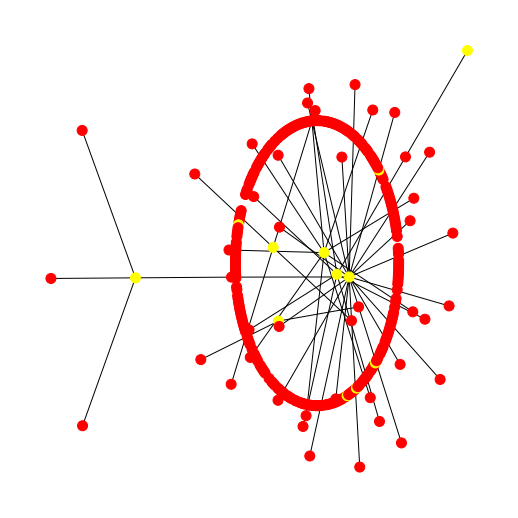

In [54]:
visualize_graph(
    Graph       = G.subgraph(random.sample(G.nodes, 300)),
    node_size   = 100,
    with_labels = None,
)

In [55]:
def get_sg_kanji_with() -> nx.Graph:
    sg = nx.Graph()
    p = '痘-kanji'
    radicals = [n for n in G.neighbors(p)]
    sg.add_nodes_from([(p, G.nodes[p])] + [(r, G.nodes[r]) for r in radicals])
    sg.add_edges_from([(p, rp) for rp in radicals])
    return sg

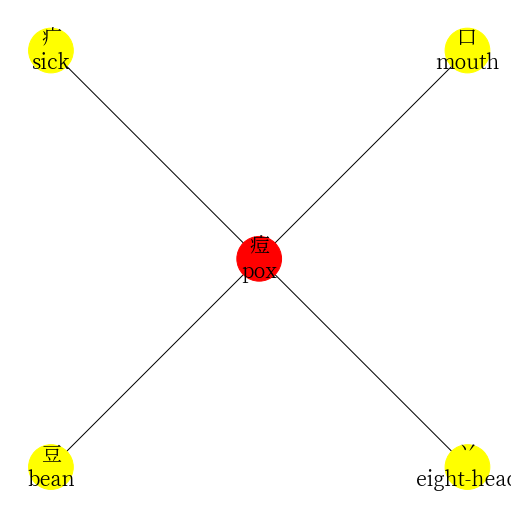

In [56]:
visualize_graph(
    Graph       = get_sg_kanji_with(),
    node_size   = 2000,
    with_labels = True,
)

# Querying Knowledge Graph

## Exploratory Data Analysis

In [21]:
print(nx.info(G))

Graph with 6470 nodes and 22273 edges


In [22]:
# https://networkx.org/documentation/stable/reference/algorithms/component.html

print('number of connected components: ', nx.number_connected_components(G))

number of connected components:  10


In [23]:
# https://networkx.org/documentation/stable/reference/algorithms/isolates.html
# EDA + Preprocessing: Removing Isolated Nodes

print('number of isolated: ', nx.number_of_isolates(G))
isolated_nodes = [n for n in nx.isolates(G)]
pp(isolated_nodes)
G.remove_nodes_from(list(nx.isolates(G)))

number of isolated:  9
['匸-radical',
 '夊-radical',
 '艸-radical',
 '辵-radical',
 '邑-radical',
 '阜-radical',
 '鬯-radical',
 '鼎-radical',
 '龍-radical']


In [24]:
print(nx.info(G))

print('number of connected components: ', nx.number_connected_components(G))

Graph with 6461 nodes and 22273 edges
number of connected components:  1


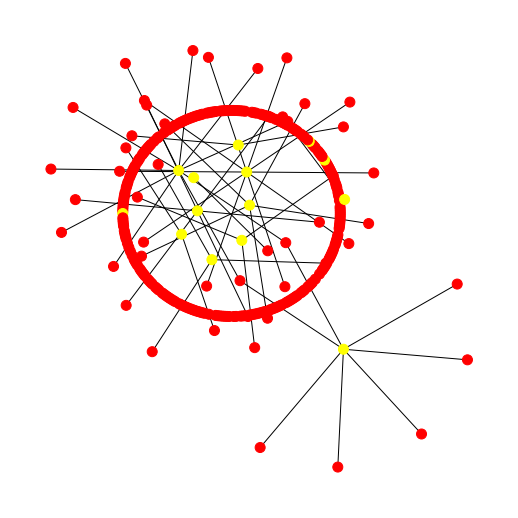

In [25]:
visualize_graph(
    Graph       = G.subgraph(random.sample(G.nodes, 300)),
    node_size   = 100,
    with_labels = None,
)

## Data Structure

In [57]:
def generate_graph(nodes: List) -> nx.Graph:
    R = nx.Graph()
    R.add_nodes_from([(n, G.nodes[n]) for n in nodes])
    R.add_edges_from(nx.utils.pairwise(nodes))
    return R

In [58]:
def get_node_color_result(kinputs, koutputs, union_result):
    G = union_result
    color_map = []
    for n in union_result:
        if n in kinputs:
            color_map.append("green")
        elif n in koutputs:
            color_map.append("blue")
        else:
            color_map.append(G.nodes[n]["color"])
    return color_map

## User Input

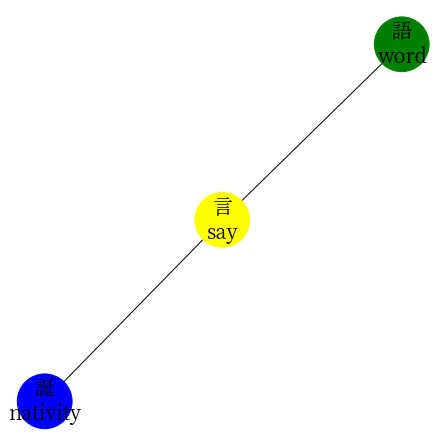

In [93]:
kin = '語-kanji'  # say
kout = '誕-kanji' # lie 

result_shortest_path = nx.shortest_path(G, source=kin, target=kout)
result = generate_graph(result_shortest_path)

visualize_graph(
    Graph=result, 
    color_map=get_node_color_result([kin], [kout], result), 
    figsize=(6,6)
)

### Test Case

In [59]:
def get_tc(filepath: str):
    fullpath = f"testcase/{filepath}"
    with open(fullpath) as file:
        return [row.strip() for row in file.readlines()]
    return None

In [69]:
tc_kanji_raw = [(get_tc(f"{i}.in"),get_tc(f"{i}.out")) for i in range(1,6)]

tc_kanji_clean = [{
        'MOrig': [f"{o}-kanji" for o in tc[0] if f"{o}-kanji" in G.nodes],
        'MDest': [f"{o}-kanji" for o in tc[1] if f"{o}-kanji" in G.nodes]
    } for tc in tc_kanji_raw]

In [76]:
tc_kanji_clean

[{'MOrig': ['口-kanji'],
  'MDest': ['見-kanji', '出-kanji', '未-kanji', '来-kanji', '了-kanji', '思-kanji']},
 {'MOrig': ['丁-kanji', '行-kanji', '寺-kanji', '時-kanji', '上-kanji'],
  'MDest': ['分-kanji',
   '禾-kanji',
   '私-kanji',
   '中-kanji',
   '尹-kanji',
   '事-kanji',
   '可-kanji',
   '何-kanji',
   '乂-kanji',
   '皮-kanji',
   '彼-kanji',
   '間-kanji',
   '本-kanji']},
 {'MOrig': ['気-kanji',
   '干-kanji',
   '年-kanji',
   '三-kanji',
   '者-kanji',
   '前-kanji',
   '勿-kanji'],
  'MDest': ['家-kanji',
   '今-kanji',
   '下-kanji',
   '勺-kanji',
   '的-kanji',
   '云-kanji',
   '物-kanji',
   '矢-kanji',
   '知-kanji',
   '乍-kanji',
   '作-kanji',
   '書-kanji',
   '学-kanji',
   '合-kanji',
   '夂-kanji',
   '後-kanji',
   '持-kanji',
   '古-kanji',
   '居-kanji',
   '無-kanji',
   '羊-kanji',
   '様-kanji',
   '音-kanji',
   '意-kanji',
   '也-kanji',
   '地-kanji',
   '午-kanji',
   '卸-kanji',
   '御-kanji',
   '至-kanji',
   '屋-kanji',
   '廿-kanji',
   '度-kanji',
   '同-kanji',
   '不-kanji',
   '実-kanji',
   '千-kanji',


In [72]:
pp(tc_kanji_clean[1])

{'MDest': ['分-kanji',
           '禾-kanji',
           '私-kanji',
           '中-kanji',
           '尹-kanji',
           '事-kanji',
           '可-kanji',
           '何-kanji',
           '乂-kanji',
           '皮-kanji',
           '彼-kanji',
           '間-kanji',
           '本-kanji'],
 'MOrig': ['丁-kanji', '行-kanji', '寺-kanji', '時-kanji', '上-kanji']}


## Algorithm

### Brute Force Algorithm

In [75]:
def find_path_bf(G: nx.Graph, MOrig: List, MDest: List) -> nx.Graph:
    
    result = []
    
    for kin in MOrig:
        for kout in MDest:
            sp_raw = nx.dijkstra_path(G, source=kin, target=kout)
            sp_graph = generate_graph(sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

In [90]:
MOrig = tc_kanji_clean[1]["MOrig"]
MDest = tc_kanji_clean[1]["MDest"]

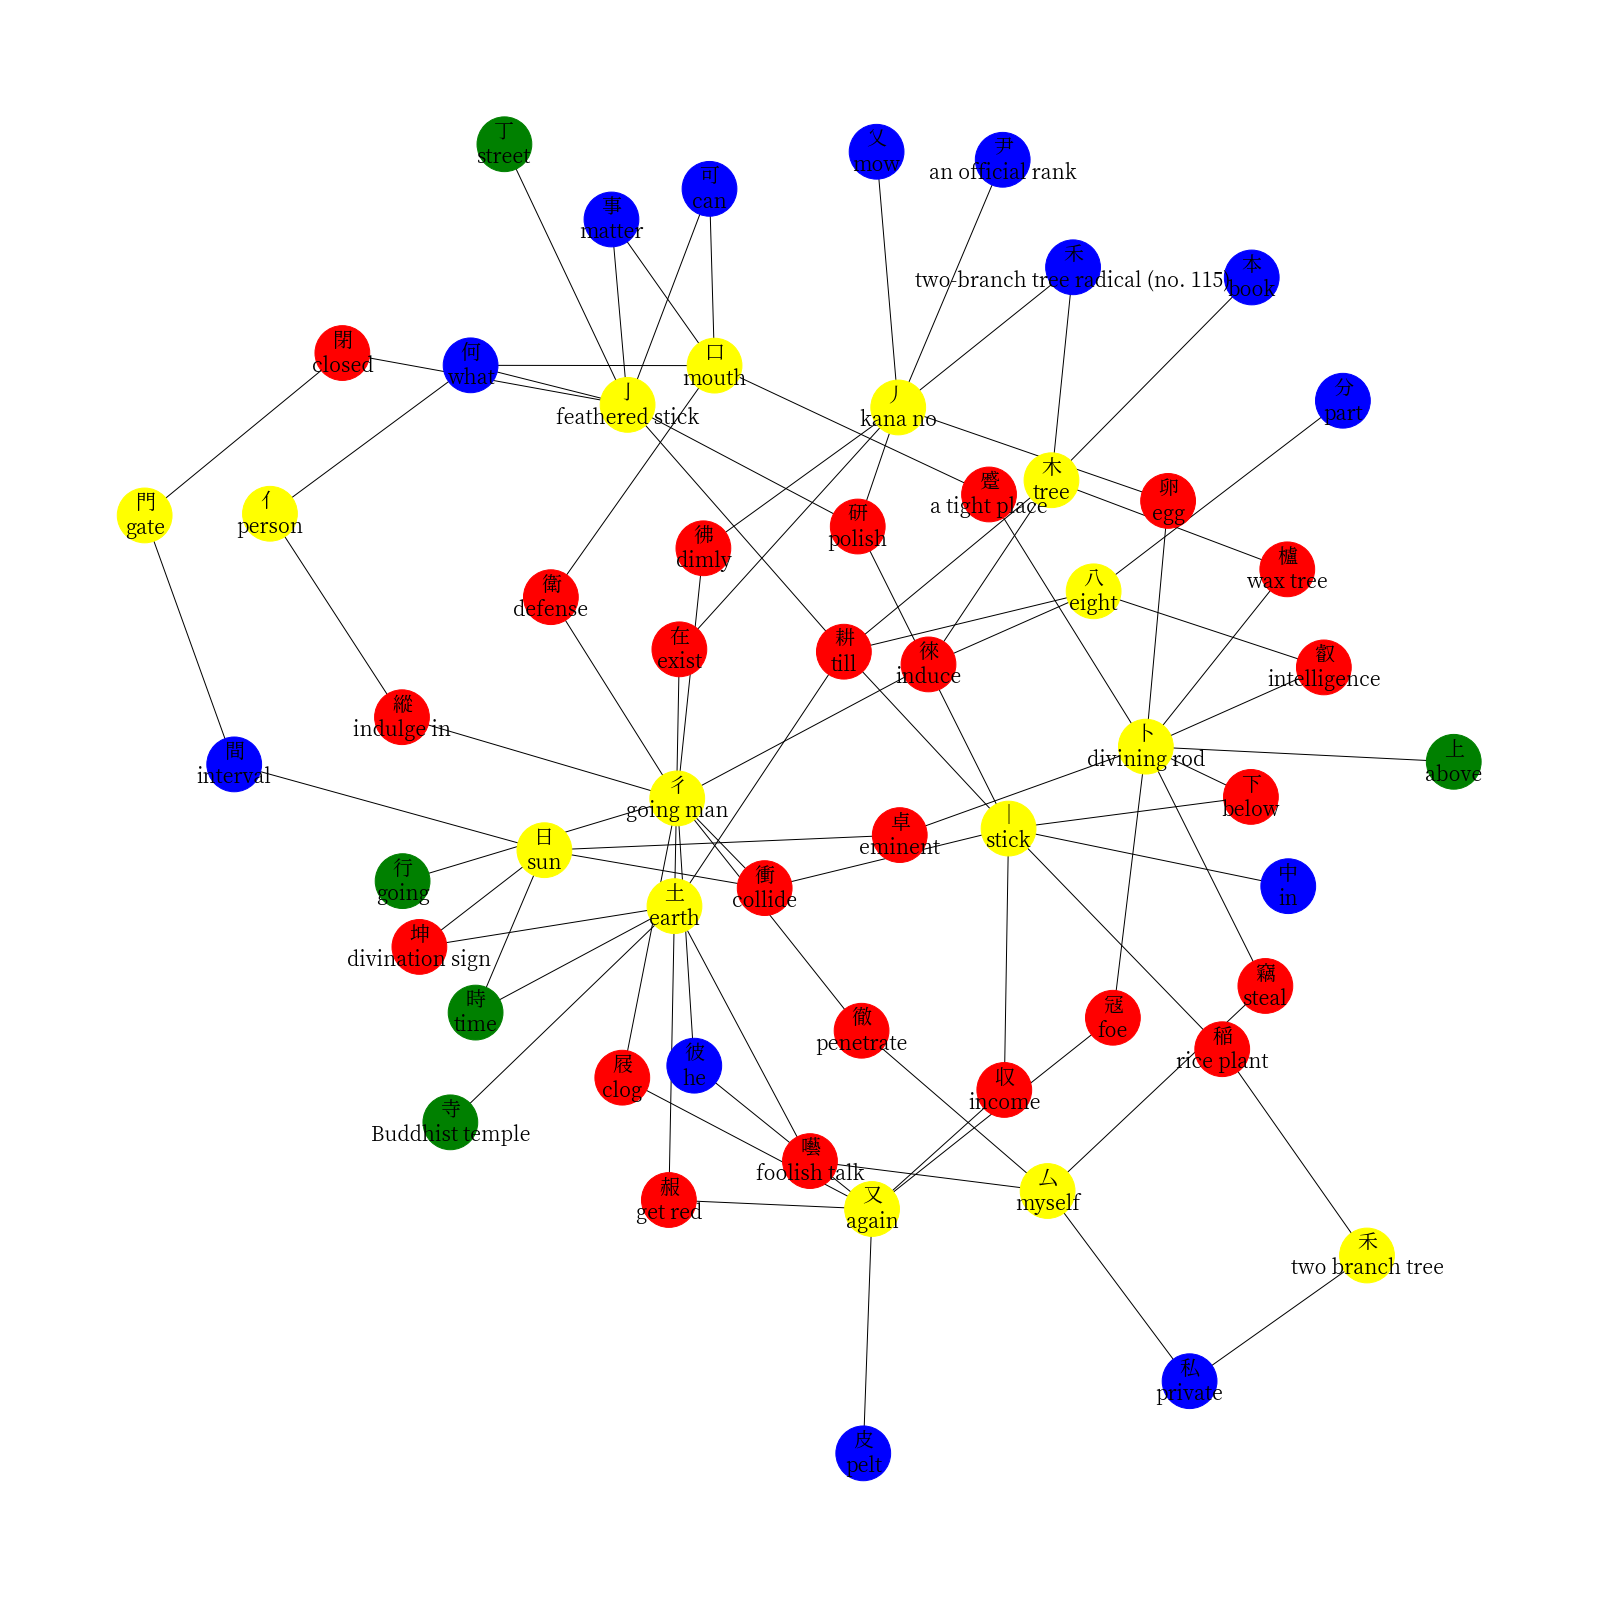

In [92]:
result = find_path_bf(G, MOrig, MDest)
visualize_graph(
    Graph=result, 
    color_map=get_node_color_result(MOrig, MDest, result), 
    figsize=(22,22)
)

### Astar Algorithm

In [111]:
def find_path_astar(G: nx.Graph, MOrig: List, MDest: List, heuristic_func) -> nx.Graph:
    
    result = []
    
    for kin in MOrig:
        for kout in MDest:
            sp_raw = nx.astar_path(G, source=kin, target=kout, heuristic=heuristic_func)
            sp_graph = generate_graph(sp_raw)
            
            result.append(sp_graph)
    
    
    return nx.compose_all(result)        

#### Heuristic

In [112]:
def common_neighbor(u, v):
    return len(list(nx.common_neighbors(G, u, v)))

In [113]:
def jaccard_function(u, v):
    union_size = len(set(G[u]) | set(G[v])) # union neighbor
    if union_size == 0:
        return 0
    return len(list(nx.common_neighbors(G, u, v))) / union_size

### Steiner Tree

In [114]:
all_pairs_dijkstra = nx.all_pairs_dijkstra(G, weight='weight')

In [115]:
def metric_closure(G, weight="weight"):
    M = nx.Graph()

    Gnodes = set(G)

    # check for connected graph while processing first node
    all_paths_iter = all_pairs_dijkstra
    u, (distance, path) = next(all_paths_iter)
    if Gnodes - set(distance):
        msg = "G is not a connected graph. metric_closure is not defined."
        raise nx.NetworkXError(msg)
    Gnodes.remove(u)
    for v in Gnodes:
        M.add_edge(u, v, distance=distance[v], path=path[v])

    # first node done -- now process the rest
    for u, (distance, path) in all_paths_iter:
        Gnodes.remove(u)
        for v in Gnodes:
            M.add_edge(u, v, distance=distance[v], path=path[v])

    return M

In [116]:
def steiner_tree(G, terminal_nodes, weight="weight"):
    # H is the subgraph induced by terminal_nodes in the metric closure M of G.
    M = metric_closure(G, weight=weight)
    H = M.subgraph(terminal_nodes)
    # Use the 'distance' attribute of each edge provided by M.
    mst_edges = nx.minimum_spanning_edges(H, weight="distance", data=True)
    # Create an iterator over each edge in each shortest path; repeats are okay
    edges = chain.from_iterable(pairwise(d["path"]) for u, v, d in mst_edges)
    # For multigraph we should add the minimal weight edge keys
    if G.is_multigraph():
        edges = (
            (u, v, min(G[u][v], key=lambda k: G[u][v][k][weight])) for u, v in edges
        )
    T = G.edge_subgraph(edges)
    return T

In [117]:
def find_path_steiner(G: nx.Graph, MOrig: List, MDest: List) -> nx.Graph:
    
    return nx.steiner_tree(G, MOrig + MDest)     

In [118]:
# result = find_path_steiner(MOrig, MDest)
# result.nodes()

# Evaluation

In [119]:
def find_path(G: nx.Graph, MOrig: List, MDest: List, method='brute_force') -> nx.Graph:
    if method == 'brute_force':
        return find_path_bf(G, MOrig, MDest)
    elif method == 'steiner_tree':
        return find_path_steiner(G, MOrig, MDest)
    elif method == 'astar_common_neighbor':
        return find_path_astar(G, MOrig, MDest, common_neighbor)
    elif method == 'astar_jaccard':
        return find_path_astar(G, MOrig, MDest, jaccard_function)
    elif method == 'astar_0':
        return find_path_astar(G, MOrig, MDest, lambda x, y: 0)
    else:
        raise ValueError(f"method {method} is not valid")

## Testing

In [120]:
import time

start = time.time()
print("hello")
end = time.time()
print(f"{end - start} seconds")

hello
0.00013208389282226562 seconds


In [121]:
tc_kanji_clean = [tc for tc in tc_kanji_clean if tc['MOrig'] and tc['MDest']]

In [122]:
tc_kanji_clean

[{'MOrig': ['口-kanji'],
  'MDest': ['見-kanji', '出-kanji', '未-kanji', '来-kanji', '了-kanji', '思-kanji']},
 {'MOrig': ['丁-kanji', '行-kanji', '寺-kanji', '時-kanji', '上-kanji'],
  'MDest': ['分-kanji',
   '禾-kanji',
   '私-kanji',
   '中-kanji',
   '尹-kanji',
   '事-kanji',
   '可-kanji',
   '何-kanji',
   '乂-kanji',
   '皮-kanji',
   '彼-kanji',
   '間-kanji',
   '本-kanji']},
 {'MOrig': ['気-kanji',
   '干-kanji',
   '年-kanji',
   '三-kanji',
   '者-kanji',
   '前-kanji',
   '勿-kanji'],
  'MDest': ['家-kanji',
   '今-kanji',
   '下-kanji',
   '勺-kanji',
   '的-kanji',
   '云-kanji',
   '物-kanji',
   '矢-kanji',
   '知-kanji',
   '乍-kanji',
   '作-kanji',
   '書-kanji',
   '学-kanji',
   '合-kanji',
   '夂-kanji',
   '後-kanji',
   '持-kanji',
   '古-kanji',
   '居-kanji',
   '無-kanji',
   '羊-kanji',
   '様-kanji',
   '音-kanji',
   '意-kanji',
   '也-kanji',
   '地-kanji',
   '午-kanji',
   '卸-kanji',
   '御-kanji',
   '至-kanji',
   '屋-kanji',
   '廿-kanji',
   '度-kanji',
   '同-kanji',
   '不-kanji',
   '実-kanji',
   '千-kanji',


## Get Results: Node and Time

In [125]:
def get_results_kanjigen(G: nx.Graph, algo_list: List):
    results = {algo: dict() for algo in algo_list}

    for idx, tc in enumerate(tc_kanji_clean):
        MOrig = tc['MOrig']
        MDest = tc['MDest']

        for algo in algo_list:
            print(f"algo: {algo}")
            print(f"tc: {idx} of {len(tc_kanji_clean)}")
            print("==============")
            start  = time.time()
            result = find_path(G, MOrig, MDest, algo)
            end    = time.time()

            results[algo][idx] = {'time': (end - start), 'result': result}
    
    return results

In [ ]:
algo_list = ['brute_force', 'astar_common_neighbor', 'astar_jaccard', 'astar_0']
results = get_results_kanjigen(G, algo_list)

algo: brute_force
tc: 0 of 5
algo: astar_common_neighbor
tc: 0 of 5
algo: astar_jaccard
tc: 0 of 5
algo: astar_0
tc: 0 of 5
algo: brute_force
tc: 1 of 5
algo: astar_common_neighbor
tc: 1 of 5
algo: astar_jaccard
tc: 1 of 5
algo: astar_0
tc: 1 of 5
algo: brute_force
tc: 2 of 5
algo: astar_common_neighbor
tc: 2 of 5
algo: astar_jaccard
tc: 2 of 5


In [ ]:
results

## Get Results: Accuracy

### Baseline: Brute Force

In [ ]:
# https://networkx.org/documentation/stable/reference/algorithms/similarity.html

### Results Accuracy

In [ ]:
G1 = nx.cycle_graph(6)
G2 = nx.wheel_graph(7)
nx.graph_edit_distance(G1, G2)